## Imports

In [41]:
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision import transforms, models, datasets
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import memory_profiler

## 1. MNIST Dataset Overview
The MNIST (Modified National Institute of Standards and Technology) dataset is a well-known benchmark dataset for image classification tasks, particularly in deep learning and computer vision. It consists of grayscale images of handwritten digits (0-9) and is widely used for training and testing machine learning models.

Dataset Details:
* Total Size: 70,000 images
* Training Set: 60,000 images
* Test Set: 10,000 images
* Number of Classes: 10 (Digits 0-9)
* Image Dimensions: 28x28 pixels (Grayscale)

## 2.0 & 2.1 Prepare the MNIST dataset

In [42]:
# Specify the root directory where the dataset will be stored/downloaded
root_dir = './data'

# Load the training dataset
train_dataset = datasets.MNIST(root=root_dir, train=True, download=True)

# Load the test dataset
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True)

###  Print some details about the training dataset

In [43]:
print(f"Classes: {train_dataset.classes}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset[0]}")
img, target = next(iter(train_dataset))
print(f"Class: {train_dataset.classes[target]}")
img

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Samples: 60000
First sample: (<PIL.Image.Image image mode=L size=28x28 at 0x25E8509BCE0>, 5)
Class: 5 - five


Our images will be 28x28 varrying from handwritten numbers 0-9

In [44]:
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.size}")

Image data type: <class 'PIL.Image.Image'>
     Image size: (28, 28)


# 2.2 Dataloader & Datasets

## Convert to Tensors & add transforms

In the transforms we will ensure that the images stay grayscale, along with adding random variations like: 
* Random Rotations (±20 degrees)
* Random Gaussian blur

Lastly, we will convert to tensor and then normalize the data. All this will help add more variation hopefully allowing the model to learn better.

In [45]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale (MNIST is already grayscale)
    transforms.RandomRotation(degrees=20),  # Randomly rotate images by up to ±20 degrees
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply random Gaussian blur
    transforms.Resize((28, 28)),  # Resize to 28x28 (MNIST size)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1] range
])

In [46]:
train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

Data loader for training, and test loader for validation. We will use batch sizes of 256, and shuffle to give more variation 

In [47]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_dataset,          # our raw data
                                           batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
                                           shuffle=True,           # shuffle our data before batching
                                           drop_last=False)        # don't drop the last batch even if it's smaller than batch_size

In [48]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         drop_last=False)        # don't drop the last batch even if it's smaller than batch_size

In [49]:
imgs, targets = next(iter(train_loader))
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {targets.shape}")

       # of batches: 235
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([256, 1, 28, 28])
  Target batch size: torch.Size([256])


# Test data loader

### Some examples of the data

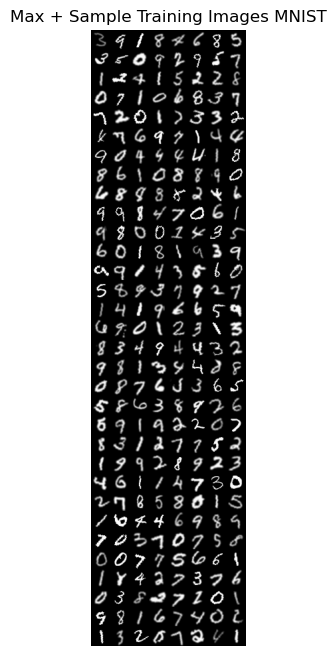

In [50]:
# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Max + Sample Training Images MNIST")
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

# Building a CNN model

In [51]:
    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
            self.relu1 = nn.ReLU()
            self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.relu2 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc = nn.Linear(32 * 7 * 7, 10)

        def forward(self, x):
            out = self.maxpool1(self.relu1(self.conv1(x)))
            out = self.maxpool2(self.relu2(self.conv2(out)))
            out = out.view(-1, 32 * 7 * 7)
            out = self.fc(out)
            return out
        

In [52]:
def trainer(model, criterion, optimizer, trainloader, testloader, epochs=5, verbose=True):
    """
    Train and validate a PyTorch model.
    
    Args:
        model: PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        trainloader: DataLoader for training data.
        validloader: DataLoader for validation data.
        epochs: Number of epochs for training.
        verbose: If True, print progress for each epoch.
    
    Returns:
        A dictionary containing training loss, validation loss, and validation accuracy.
    """
    
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_batch_loss += loss.item() # Accumulate batch loss
            
        train_loss.append(train_batch_loss / len(trainloader)) # Compute average training loss for this epoch
        
        # Validation
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)  # Compute validation loss
                
                valid_batch_loss += loss.item()  # Accumulate validation batch loss
                
                # Compute accuracy: compare predicted labels to actual labels
                _, predicted = torch.max(outputs, 1)
                valid_batch_acc += (predicted == labels).float().mean().item()
                
            valid_loss.append(valid_batch_loss / len(testloader))  # Compute average validation loss
            valid_accuracy.append(valid_batch_acc / len(testloader))  # Compute average validation accuracy
            
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results    

# Define and train the model

In [53]:
# Define and train model
# GPU available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")
# Model
model = CNN()
model.to(device);

# Define the loss function
# nn.BCEWithLogitsLoss() combines a sigmoid activation with binary cross-entropy loss
# This is typically used for binary classification problems
criterion = nn.CrossEntropyLoss() 


#Define the optimizer
# optim.Adam() is an Adam optimizer that adjusts the model's weights using gradients
# model.parameters() ensures the optimizer updates all trainable model parameters
optimizer = optim.Adam(model.parameters())

#Train the model using the trainer function
results = trainer(model, criterion, optimizer, train_loader, test_loader, epochs=100)

Using: cuda
Epoch 1: Train Loss: 0.566. Valid Loss: 0.196. Valid Accuracy: 0.94.
Epoch 2: Train Loss: 0.160. Valid Loss: 0.114. Valid Accuracy: 0.97.
Epoch 3: Train Loss: 0.115. Valid Loss: 0.099. Valid Accuracy: 0.97.
Epoch 4: Train Loss: 0.099. Valid Loss: 0.086. Valid Accuracy: 0.97.
Epoch 5: Train Loss: 0.089. Valid Loss: 0.081. Valid Accuracy: 0.97.
Epoch 6: Train Loss: 0.083. Valid Loss: 0.079. Valid Accuracy: 0.98.
Epoch 7: Train Loss: 0.076. Valid Loss: 0.074. Valid Accuracy: 0.98.
Epoch 8: Train Loss: 0.072. Valid Loss: 0.066. Valid Accuracy: 0.98.
Epoch 9: Train Loss: 0.068. Valid Loss: 0.062. Valid Accuracy: 0.98.
Epoch 10: Train Loss: 0.063. Valid Loss: 0.064. Valid Accuracy: 0.98.
Epoch 11: Train Loss: 0.061. Valid Loss: 0.054. Valid Accuracy: 0.98.
Epoch 12: Train Loss: 0.059. Valid Loss: 0.051. Valid Accuracy: 0.98.
Epoch 13: Train Loss: 0.056. Valid Loss: 0.050. Valid Accuracy: 0.98.
Epoch 14: Train Loss: 0.053. Valid Loss: 0.051. Valid Accuracy: 0.98.
Epoch 15: Train L

# Visualizing loss and accuracy

## Training & Validation Loss Curves

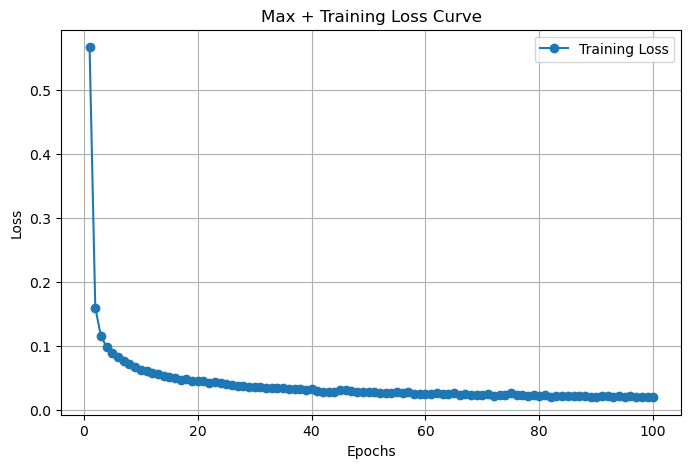

In [93]:
# Extract metrics from the results dictionary
train_loss = results["train_loss"]       # Training loss per epoch
valid_loss = results["valid_loss"]       # Validation loss per epoch


# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o')  # Training loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Max + Training Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

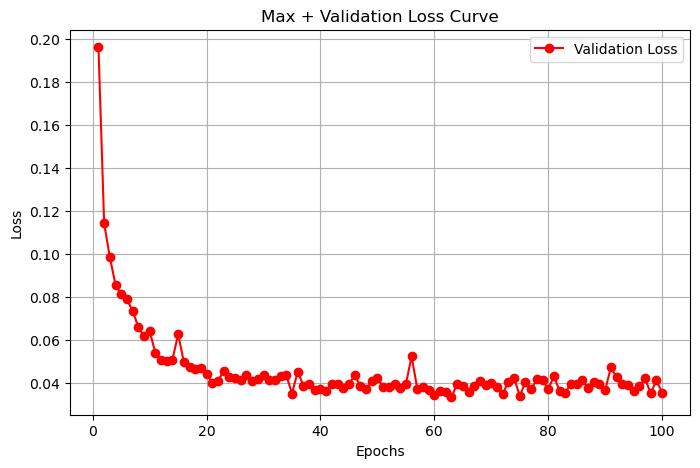

In [94]:
# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation Loss", marker='o', color='red')  # Validation loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Max + Validation Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

## Compare Training & Validation Loss

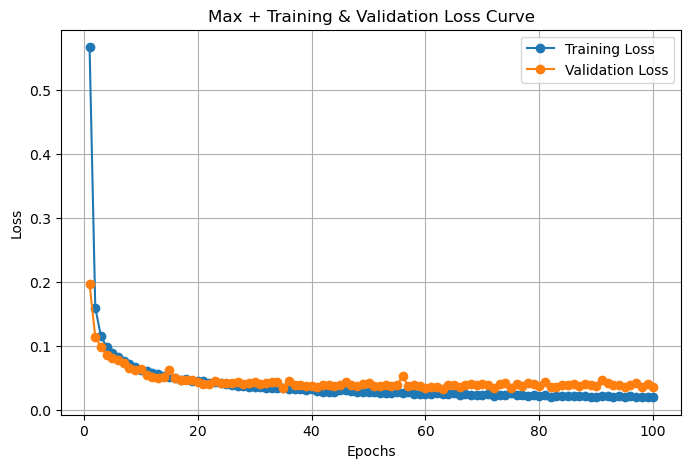

In [96]:
# Plot Training and Validation Loss Curve
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o')  # Training loss
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label="Validation Loss", marker='o')  # Validation loss
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Max + Training & Validation Loss Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

When comparing the traning and validation loss curves, it seems that the model is not overfitted as both curves seem to stay relatively close. There are also no signs over underfitting as both loss values are low. 

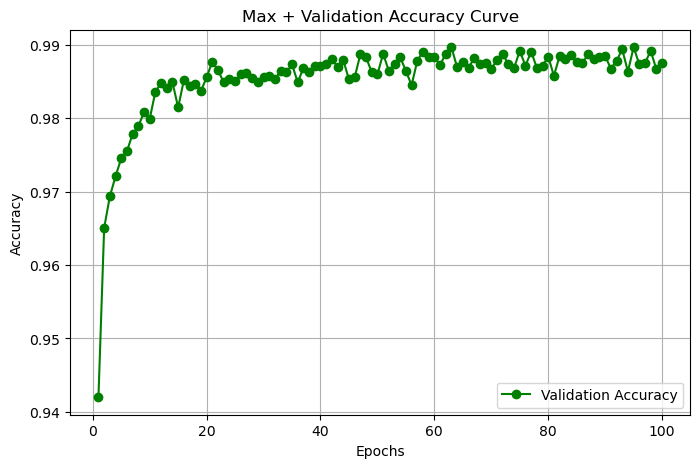

In [98]:
valid_accuracy = results["valid_accuracy"]  # Validation accuracy per epoch

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label="Validation Accuracy", color='green', marker='o')
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.title("Max + Validation Accuracy Curve")  # Plot title
plt.legend()  # Add a legend
plt.grid()  # Add grid lines for better readability
plt.show()

# Predicted vs. Actual Labels

We will take a batch of images from the test dataset and visually show what the model is guessing versus what the actual value is.

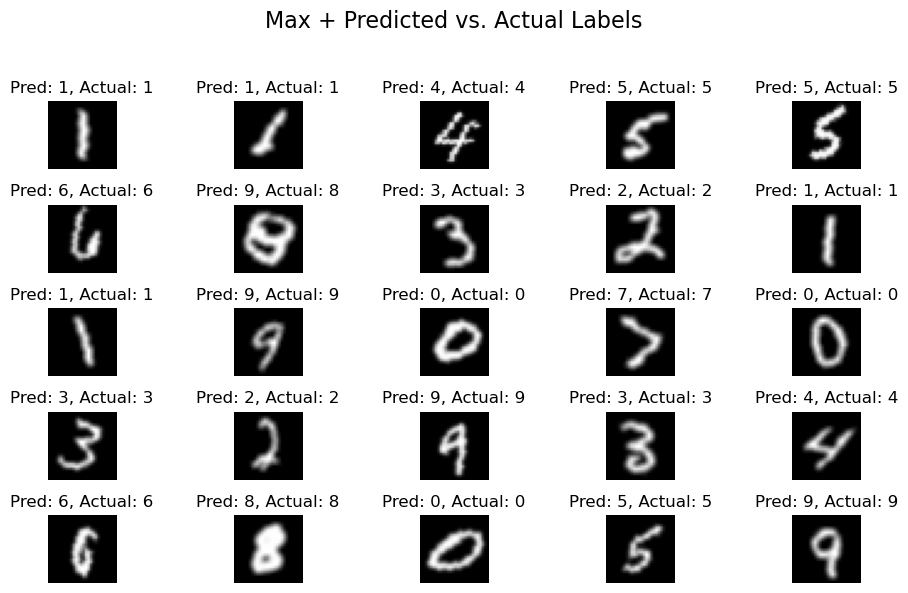

In [113]:
# Get a batch of test images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to the same device as the model
images = images

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot some images with predicted and actual labels
fig, axes = plt.subplots(5, 5, figsize=(10, 6))
fig.suptitle("Max + Predicted vs. Actual Labels", fontsize=16)  # Add title
axes = axes.ravel()

for i in range(25):  # Display 15 images
    img = images[i].cpu().squeeze().numpy()  # Convert to NumPy for visualization
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Pred: {preds[i].item()}, Actual: {labels[i].item()}")
    axes[i].axis('off')
    
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

## Confusion matrix

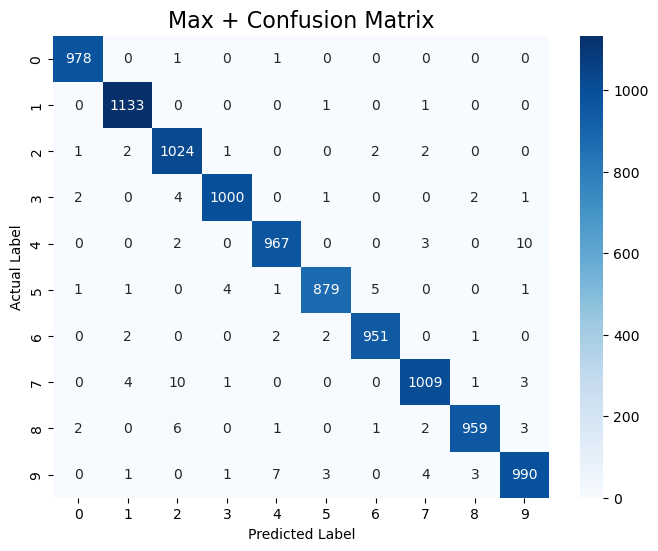

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get all predictions and actual labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Max + Confusion Matrix", fontsize=16)  # Add title
plt.show()

From this confusion matrix we can see that the model struggles the most with classifying 7's and 9's but overall only misclassifies 110 times out of 10,000 images (1.1%). We can tell from this matrix that the model seems to mix up 4's for 9's and 7's for 2's. 

# Save model and load

In [108]:
# Save the model and load it
PATH = "models/MNIST_e50.pt"
# Save model
torch.save(model.state_dict(), PATH)

# Loading the model
model = CNN()
model.load_state_dict(torch.load(PATH))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

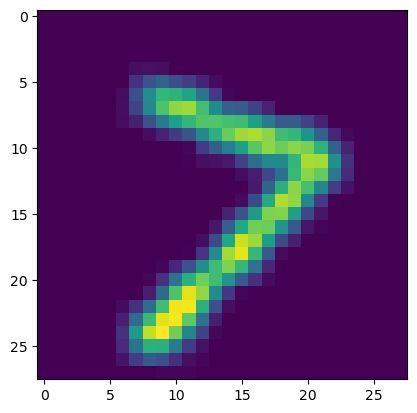

In [114]:
image = next(iter(test_dataset))
plt.imshow(np.transpose(image[0],(1,2,0)))

In [115]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations (for inference)
    output = model(image[0])  # Pass the image through the model

predicted_class = torch.argmax(output, dim=1).item()  # Get the index of the highest logit
print(f"Predicted Class: {predicted_class}")

Predicted Class: 7
